In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
import func_get
import func_signal
import func_backtest

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/read.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'messi'

In [7]:
start_date = dt.datetime(2022, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '2h',
    'target_side': ['buy', 'sell'],
    'base': {
        'symbol': ['ETH-PERP'],
        'open': {
            '2h': {
                'tma': {
                    'check': ['check_signal_side_change'],
                    'look_back': 1,
                    'windows': 50,
                    'revert': False
                }
            }
        },
        'close': {
            '2h': {
                'tma': {
                    'check': ['check_signal_side'],
                    'look_back': 1,
                    'windows': 50,
                    'revert': False
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None
    },
    'action_percent': 100,
    'leverage': 1,
    'taker_fee_percent': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = func_get.get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/342
base: timeframe 1/1 symbol 1/1 date 2/342
base: timeframe 1/1 symbol 1/1 date 3/342
base: timeframe 1/1 symbol 1/1 date 4/342
base: timeframe 1/1 symbol 1/1 date 5/342
base: timeframe 1/1 symbol 1/1 date 6/342
base: timeframe 1/1 symbol 1/1 date 7/342
base: timeframe 1/1 symbol 1/1 date 8/342
base: timeframe 1/1 symbol 1/1 date 9/342
base: timeframe 1/1 symbol 1/1 date 10/342
base: timeframe 1/1 symbol 1/1 date 11/342
base: timeframe 1/1 symbol 1/1 date 12/342
base: timeframe 1/1 symbol 1/1 date 13/342
base: timeframe 1/1 symbol 1/1 date 14/342
base: timeframe 1/1 symbol 1/1 date 15/342
base: timeframe 1/1 symbol 1/1 date 16/342
base: timeframe 1/1 symbol 1/1 date 17/342
base: timeframe 1/1 symbol 1/1 date 18/342
base: timeframe 1/1 symbol 1/1 date 19/342
base: timeframe 1/1 symbol 1/1 date 20/342
base: timeframe 1/1 symbol 1/1 date 21/342
base: timeframe 1/1 symbol 1/1 date 22/342
base: timeframe 1/1 symbol 1/1 date 23/342
base: timeframe 1/1 

base: timeframe 1/1 symbol 1/1 date 190/342
base: timeframe 1/1 symbol 1/1 date 191/342
base: timeframe 1/1 symbol 1/1 date 192/342
base: timeframe 1/1 symbol 1/1 date 193/342
base: timeframe 1/1 symbol 1/1 date 194/342
base: timeframe 1/1 symbol 1/1 date 195/342
base: timeframe 1/1 symbol 1/1 date 196/342
base: timeframe 1/1 symbol 1/1 date 197/342
base: timeframe 1/1 symbol 1/1 date 198/342
base: timeframe 1/1 symbol 1/1 date 199/342
base: timeframe 1/1 symbol 1/1 date 200/342
base: timeframe 1/1 symbol 1/1 date 201/342
base: timeframe 1/1 symbol 1/1 date 202/342
base: timeframe 1/1 symbol 1/1 date 203/342
base: timeframe 1/1 symbol 1/1 date 204/342
base: timeframe 1/1 symbol 1/1 date 205/342
base: timeframe 1/1 symbol 1/1 date 206/342
base: timeframe 1/1 symbol 1/1 date 207/342
base: timeframe 1/1 symbol 1/1 date 208/342
base: timeframe 1/1 symbol 1/1 date 209/342
base: timeframe 1/1 symbol 1/1 date 210/342
base: timeframe 1/1 symbol 1/1 date 211/342
base: timeframe 1/1 symbol 1/1 d

### Add signal

In [10]:
ohlcv_df_dict = func_signal.add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add tma to ETH-PERP 2h


### Back test

In [11]:
action_time_list = func_get.gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = func_backtest.get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'value': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = func_backtest.close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / (config_params['action_percent'] / 100))

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = func_backtest.open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    close_percent = 100
    
    budget, position_dict, transaction_dict = func_backtest.update_close_position(symbol, side, close_price, close_percent, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2022-01-01 03:00:00: progress 1/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 05:00:00: progress 2/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 07:00:00: progress 3/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 09:00:00: progress 4/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 11:00:00: progress 5/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 13:00:00: progress 6/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 15:00:00: progress 7/2100
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 17:00:00: progress 8/2100
  ETH-PERP
     base ETH-PERP check_signal_side_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-16 05:00:00: progress 182/2100
  ETH-PERP
       side: buy
       price: 3325.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-16 07:00:00: progress 183/2100
  ETH-PERP
       side: buy
       price: 3324.8
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-16 09:00:00: progress 184/2100
  ETH-PERP
       side: buy
       price: 3315.9
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-16 11:00:00: progress 185/2100
  ETH-PERP
       side: buy
       price: 3296.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-16 13:00:00: progress 186/2100
  ETH-PERP
       side: buy
       price: 3309.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma

       side: sell
       price: 2329.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-28 09:00:00: progress 328/2100
  ETH-PERP
       side: sell
       price: 2385.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-28 11:00:00: progress 329/2100
  ETH-PERP
       side: sell
       price: 2362.4
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-28 13:00:00: progress 330/2100
  ETH-PERP
       side: sell
       price: 2425.4
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-28 15:00:00: progress 331/2100
  ETH-PERP
       side: sell
       price: 2388.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-28 17:00:00: progress 332/2100
  ETH-PERP
       side: sell
  

     Not close
Time 2022-02-10 11:00:00: progress 485/2100
  ETH-PERP
       side: buy
       price: 3171.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 13:00:00: progress 486/2100
  ETH-PERP
       side: buy
       price: 3158.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 15:00:00: progress 487/2100
  ETH-PERP
       side: buy
       price: 3170.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 17:00:00: progress 488/2100
  ETH-PERP
       side: buy
       price: 3186.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 19:00:00: progress 489/2100
  ETH-PERP
       side: buy
       price: 3214.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 21:00:00:

     Not close
Time 2022-02-15 13:00:00: progress 546/2100
  ETH-PERP
       side: buy
       price: 3008.7
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-15 15:00:00: progress 547/2100
  ETH-PERP
       side: buy
       price: 3014.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-15 17:00:00: progress 548/2100
  ETH-PERP
       side: buy
       price: 3042.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-15 19:00:00: progress 549/2100
  ETH-PERP
       side: buy
       price: 3086.7
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-15 21:00:00: progress 550/2100
  ETH-PERP
       side: buy
       price: 3089.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-15 23:00:00:

       side: buy
       price: 2586.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-25 15:00:00: progress 667/2100
  ETH-PERP
       side: buy
       price: 2597.8
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-25 17:00:00: progress 668/2100
  ETH-PERP
       side: buy
       price: 2573.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-25 19:00:00: progress 669/2100
  ETH-PERP
       side: buy
       price: 2600.0
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-25 21:00:00: progress 670/2100
  ETH-PERP
       side: buy
       price: 2633.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-25 23:00:00: progress 671/2100
  ETH-PERP
       side: buy
       price: 2657.5
  

       side: buy
       price: 2956.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-02 17:00:00: progress 728/2100
  ETH-PERP
       side: buy
       price: 2952.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-02 19:00:00: progress 729/2100
  ETH-PERP
       side: buy
       price: 2987.8
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-02 21:00:00: progress 730/2100
  ETH-PERP
       side: buy
       price: 2927.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-02 23:00:00: progress 731/2100
  ETH-PERP
       side: buy
       price: 2942.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-03 01:00:00: progress 732/2100
  ETH-PERP
       side: buy
       price: 2944.3
  

     Not close
Time 2022-03-12 15:00:00: progress 847/2100
  ETH-PERP
       side: sell
       price: 2580.5
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-12 17:00:00: progress 848/2100
  ETH-PERP
       side: sell
       price: 2573.1
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-12 19:00:00: progress 849/2100
  ETH-PERP
       side: sell
       price: 2574.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-12 21:00:00: progress 850/2100
  ETH-PERP
       side: sell
       price: 2575.2
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-03-12 23:00:00: progress 851/2100
  ETH-PERP
       side: sell
       price: 2561.1
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-17 05:00:00: progress 902/2100
  ETH-PERP
       side: buy
       price: 2742.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-17 07:00:00: progress 903/2100
  ETH-PERP
       side: buy
       price: 2745.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-17 09:00:00: progress 904/2100
  ETH-PERP
       side: buy
       price: 2754.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-17 11:00:00: progress 905/2100
  ETH-PERP
       side: buy
       price: 2764.5
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-17 13:00:00: progress 906/2100
  ETH-PERP
       side: buy
       price: 2757.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma

       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-27 17:00:00: progress 1028/2100
  ETH-PERP
       side: buy
       price: 3142.7
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-27 19:00:00: progress 1029/2100
  ETH-PERP
       side: buy
       price: 3141.2
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-27 21:00:00: progress 1030/2100
  ETH-PERP
       side: buy
       price: 3127.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-27 23:00:00: progress 1031/2100
  ETH-PERP
       side: buy
       price: 3142.1
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-28 01:00:00: progress 1032/2100
  ETH-PERP
       side: buy
       price: 3166.9
       sl: 0
       sl_flag: False


     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-01 19:00:00: progress 1089/2100
  ETH-PERP
       side: sell
       price: 3268.3
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-01 21:00:00: progress 1090/2100
  ETH-PERP
       side: sell
       price: 3262.5
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-01 23:00:00: progress 1091/2100
  ETH-PERP
       side: sell
       price: 3351.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 3435.6
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.03747428061868768
     price: 3435.6
     tp: inf
     sl: 0
Time 2022-04-02 01:00:00: progress 1092/2100
  ETH-PERP
       side: buy
       price: 3407.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not c

       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-11 21:00:00: progress 1210/2100
  ETH-PERP
       side: sell
       price: 3012.7
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-11 23:00:00: progress 1211/2100
  ETH-PERP
       side: sell
       price: 3003.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-12 01:00:00: progress 1212/2100
  ETH-PERP
       side: sell
       price: 2977.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-12 03:00:00: progress 1213/2100
  ETH-PERP
       side: sell
       price: 2983.4
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-12 05:00:00: progress 1214/2100
  ETH-PERP
       side: sell
       price: 2947.6
       sl: inf
       sl_flag:

       side: buy
       price: 2941.4
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-04-26 23:00:00: progress 1391/2100
  ETH-PERP
       side: buy
       price: 2853.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 2859.8
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.04074207749863684
     price: 2859.8
     tp: 0
     sl: inf
Time 2022-04-27 01:00:00: progress 1392/2100
  ETH-PERP
       side: sell
       price: 2836.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-27 03:00:00: progress 1393/2100
  ETH-PERP
       side: sell
       price: 2809.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-04-27 05:00:00: progress 1394/2100
  ETH-PERP
       side: sell
       price: 2798.4
       sl: inf
      

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-09 19:00:00: progress 1545/2100
  ETH-PERP
       side: sell
       price: 2360.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-09 21:00:00: progress 1546/2100
  ETH-PERP
       side: sell
       price: 2385.4
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-09 23:00:00: progress 1547/2100
  ETH-PERP
       side: sell
       price: 2347.1
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-10 01:00:00: progress 1548/2100
  ETH-PERP
       side: sell
       price: 2249.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-10 03:00:00: progress 1549/2100
  ETH-PERP
       side: sell
       price: 2223.5
       sl: inf
       sl_flag: False
     base ETH-P

     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 1971.0
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.04384620723862993
     price: 1971.0
     tp: 0
     sl: inf
Time 2022-05-24 09:00:00: progress 1720/2100
  ETH-PERP
       side: sell
       price: 1966.3
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-24 11:00:00: progress 1721/2100
  ETH-PERP
       side: sell
       price: 1979.7
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-24 13:00:00: progress 1722/2100
  ETH-PERP
       side: sell
       price: 1977.4
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-05-24 15:00:00: progress 1723/2100
  ETH-PERP
       side: sell
       price: 1971.4
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
   

       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-05 09:00:00: progress 1864/2100
  ETH-PERP
       side: sell
       price: 1783.6
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-05 11:00:00: progress 1865/2100
  ETH-PERP
       side: sell
       price: 1783.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-05 13:00:00: progress 1866/2100
  ETH-PERP
       side: sell
       price: 1784.6
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-05 15:00:00: progress 1867/2100
  ETH-PERP
       side: sell
       price: 1784.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-05 17:00:00: progress 1868/2100
  ETH-PERP
       side: sell
       price: 1771.1
       sl: inf
       sl_flag:

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-09 17:00:00: progress 1916/2100
  ETH-PERP
       side: sell
       price: 1804.2
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 1818.4
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.0473687257237652
     price: 1818.4
     tp: inf
     sl: 0
Time 2022-06-09 19:00:00: progress 1917/2100
  ETH-PERP
       side: buy
       price: 1801.3
       sl: 0
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 1804.1
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.04730214668365986
     price: 1804.1
     tp: 0
     sl: inf
Time 2022-06-09 21:00:00: progress 1918/2100
  ETH-PERP
       side: sell
       price: 1777.1
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-09 23:00:00: progres

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-19 15:00:00: progress 2035/2100
  ETH-PERP
       side: sell
       price: 935.8
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-19 17:00:00: progress 2036/2100
  ETH-PERP
       side: sell
       price: 950.9
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-19 19:00:00: progress 2037/2100
  ETH-PERP
       side: sell
       price: 986.0
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-19 21:00:00: progress 2038/2100
  ETH-PERP
       side: sell
       price: 1016.6
       sl: inf
       sl_flag: False
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-06-19 23:00:00: progress 2039/2100
  ETH-PERP
       side: sell
       price: 1017.8
       sl: inf
       sl_flag: False
     base ETH-PERP

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 1.22 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,value,notional,profit,profit_percent
0,ETH-PERP,buy,0.026592,2022-01-02 01:00:00,3760.6,2022-01-04 03:00:00,3738.5,100.000000,100.000000,-0.727261,-0.726752
1,ETH-PERP,sell,0.026554,2022-01-04 03:00:00,3738.5,2022-01-04 07:00:00,3765.0,99.272739,99.272739,-0.843160,-0.849932
2,ETH-PERP,buy,0.026143,2022-01-04 07:00:00,3765.0,2022-01-04 09:00:00,3732.2,98.429579,98.429579,-0.994702,-1.009865
3,ETH-PERP,sell,0.026107,2022-01-04 09:00:00,3732.2,2022-01-04 15:00:00,3763.8,97.434878,97.434878,-0.961953,-0.987970
4,ETH-PERP,buy,0.025632,2022-01-04 15:00:00,3763.8,2022-01-06 01:00:00,3773.1,96.472924,96.472924,0.103147,0.106843
...,...,...,...,...,...,...,...,...,...,...,...
108,ETH-PERP,buy,0.107939,2022-06-20 03:00:00,1098.8,2022-06-22 15:00:00,1073.8,118.603888,118.603888,-2.862643,-2.411928
109,ETH-PERP,sell,0.107787,2022-06-22 15:00:00,1073.8,2022-06-22 17:00:00,1089.8,115.741244,115.741244,-1.887830,-1.632221
110,ETH-PERP,buy,0.104472,2022-06-22 17:00:00,1089.8,2022-06-22 23:00:00,1073.8,113.853414,113.853414,-1.829774,-1.606007
111,ETH-PERP,sell,0.104324,2022-06-22 23:00:00,1073.8,2022-06-24 03:00:00,1125.7,112.023640,112.023640,-5.575064,-4.980172


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 113.64


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: 6.45%


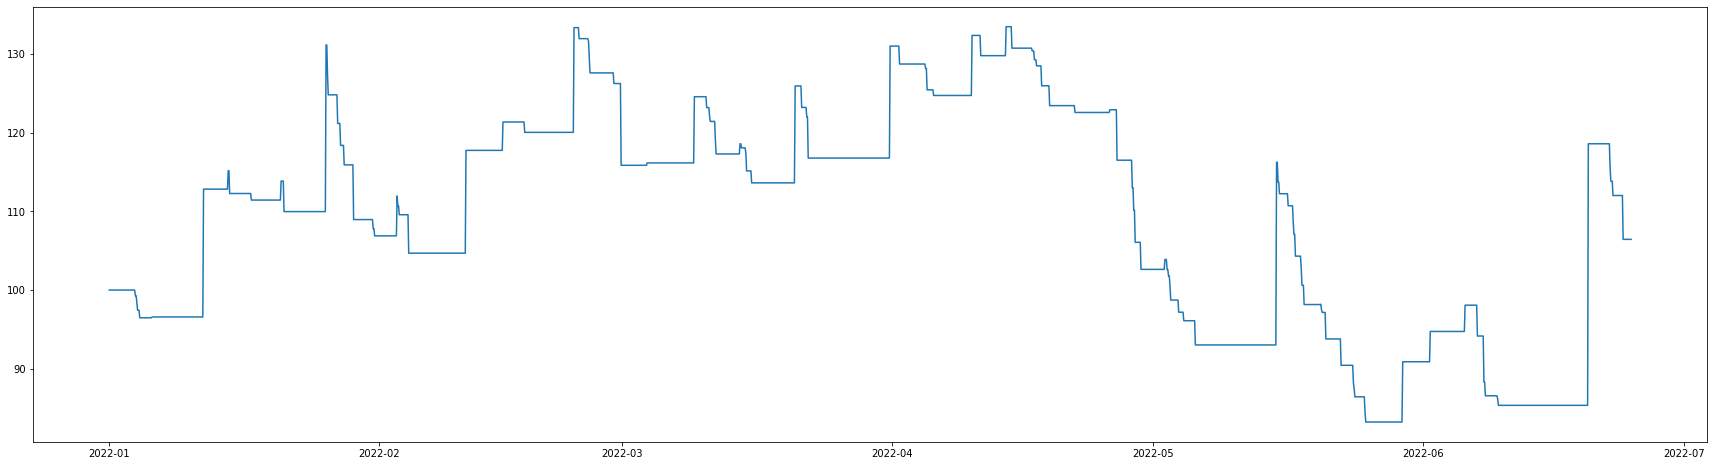

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 8.09%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 22.12%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

ETH-PERP win rate: 22.12%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count      113.000000
mean         0.275469
std          6.088677
min         -8.243055
25%         -2.113662
50%         -1.151309
75%         -0.437036
max         39.008958


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution ETH-PERP:
       profit_percent
count      113.000000
mean         0.275469
std          6.088677
min         -8.243055
25%         -2.113662
50%         -1.151309
75%         -0.437036
max         39.008958




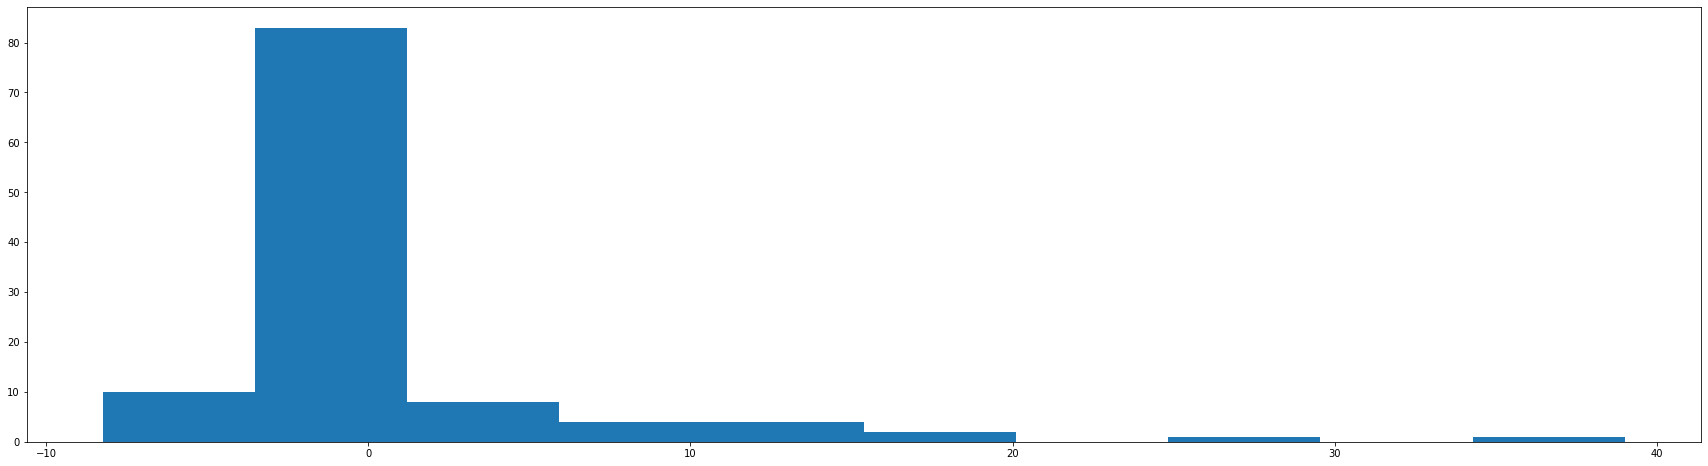

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)